In [25]:
from ultralytics import YOLO
from imageai.Detection import ObjectDetection
import os 
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model
import tensorflow.image as tfi
import random
import cv2
from PIL import Image
import sklearn
import seaborn as sbe

In [26]:
import tifffile 
direct = "images"
input_image = []
for filename in os.listdir(direct):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        filepath= os.path.join(direct,filename)
        try:
            input_image.append(np.array(tifffile.imread(filepath)))
        except Exception as e:
            print(f"Failed to load {filename}: {e}")

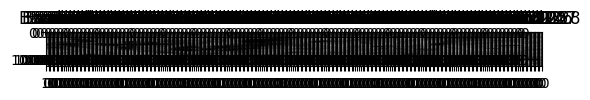

In [27]:
import matplotlib.pyplot as plt

def display_bands(image):
    for i in range(image.shape[0]):
        plt.subplot(1, image.shape[0], i + 1)
        plt.imshow(image[i],cmap='gray')
        plt.title(f'Band {i + 1}')
    plt.show()

# Example usage:
display_bands(input_image[0])

In [9]:
import glob  # To find files matching a pattern
import os    # For file path operations and deleting files
from PIL import Image  # To open and process images
import numpy as np  # To convert images to NumPy arrays
import re
# Path to the directory containing images
directory = "labels"
segmentation_labels = []
## this is used for the numerical ordering in the files name not by the string ordering 
def natural_key(file_name):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', file_name)]

image_files = sorted(glob.glob(os.path.join(directory, '*.[pjJ][npN]*[gG]*')), key=natural_key)
# Load and process each image
for file_path in image_files:
    image = Image.open(file_path)
    segmentation_labels.append(np.array(image))
    print(file_path)

labels\0.png
labels\1.png
labels\2.png
labels\3.png
labels\4.png
labels\5.png
labels\6.png
labels\7.png
labels\8.png
labels\9.png
labels\10.png
labels\11.png
labels\12.png
labels\13.png
labels\14.png
labels\15.png
labels\16.png
labels\17.png
labels\18.png
labels\19.png
labels\20.png
labels\21.png
labels\22.png
labels\23.png
labels\24.png
labels\25.png
labels\26.png
labels\27.png
labels\28.png
labels\29.png
labels\30.png
labels\31.png
labels\32.png
labels\33.png
labels\34.png
labels\35.png
labels\36.png
labels\37.png
labels\38.png
labels\39.png
labels\40.png
labels\41.png
labels\42.png
labels\43.png
labels\44.png
labels\45.png
labels\46.png
labels\47.png
labels\48.png
labels\49.png
labels\50.png
labels\51.png
labels\52.png
labels\53.png
labels\54.png
labels\55.png
labels\56.png
labels\57.png
labels\58.png
labels\59.png
labels\60.png
labels\61.png
labels\62.png
labels\63.png
labels\64.png
labels\65.png
labels\66.png
labels\67.png
labels\68.png
labels\69.png
labels\70.png
labels\71.png
la

In [12]:
print("input images:", len(input_image))
print("segmentation labels:",len(segmentation_labels))
print("shape of images:", input_image[0].shape)
print("shape of labels:", segmentation_labels[0].shape)

input images: 306
segmentation labels: 306
shape of images: (128, 128, 12)
shape of labels: (128, 128)


In [13]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler , StandardScaler 
scaled_image = []
for image in input_image:
    original = image.shape
    shaped = image.reshape(-1,original[-1])
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(shaped)
    scaled_image.append(scaled.reshape(original))

In [14]:
print(len(scaled_image))

306


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_image , val_image , train_labels , val_labels =train_test_split(scaled_image ,segmentation_labels, test_size=0.2, random_state=0)

In [18]:
print(len(train_image))
print(len(val_image))
print(len(train_labels))
print(len(val_labels))

244
62
244
62


In [19]:
print(np.array(train_image).shape)

(244, 128, 128, 12)


In [20]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


input_shape = (128 ,128, 12)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [22]:
np.array(train_image)

array([[[[    0.29551,     0.34237,     0.36879, ...,    0.015152,     0.42857,           0],
         [    0.28327,     0.32122,      0.3391, ...,    0.015152,     0.42857,           0],
         [    0.30531,     0.28685,     0.24911, ...,    0.022727,     0.42857,           0],
         ...,
         [    0.16571,     0.14475,     0.14229, ...,     0.22727,     0.42857,           0],
         [     0.1698,      0.1421,     0.13387, ...,     0.22727,     0.42857,           0],
         [    0.17469,     0.14805,     0.14672, ...,     0.22727,     0.28571,           0]],

        [[    0.27265,     0.27032,     0.28324, ...,   0.0075758,     0.42857,           0],
         [    0.30694,     0.35096,     0.38076, ...,    0.015152,     0.42857,           0],
         [    0.30041,     0.31064,      0.2992, ...,    0.022727,     0.42857,           0],
         ...,
         [    0.19265,     0.17383,     0.17465, ...,     0.22727,     0.28571,           0],
         [     0.1902,     0.1

In [21]:
model.compile(optimizer="adam",loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# train the model
train_image_array = np.array(train_image)
train_labels_array = np.array(train_labels)
val_image_array = np.array(val_image)
val_labels_array =np.array(val_labels)

In [24]:
history = model.fit(train_image_array, train_labels_array , validation_data=(val_image_array, val_labels_array), epochs=30)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 134s 15s/step - accuracy: 0.3330 - loss: 1.0836 - val_accuracy: 0.3108 - val_loss: 10.9088
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 14s/step - accuracy: 0.6942 - loss: 0.6213 - val_accuracy: 0.3111 - val_loss: 10.6228
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 123s 15s/step - accuracy: 0.7511 - loss: 0.5659 - val_accuracy: 0.3133 - val_loss: 10.6740
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 13s/step - accuracy: 0.7442 - loss: 0.5668 - val_accuracy: 0.3144 - val_loss: 10.0141
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 97s 12s/step - accuracy: 0.7639 - loss: 0.5416 - val_accuracy: 0.3422 - val_loss: 4.4466
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - accuracy: 0.7342 - loss: 0.5669 - val_accuracy: 0.4668 - val_loss: 4.4394
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 100s 13s/step - accuracy: 0.7687 - loss: 0.5298 - val_accuracy: 0.5377 - val_loss: 2.7719
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 100s 12s/step - accuracy: 0.7502 - loss: 0.5489 - val_accuracy: 0.5141 - val_los

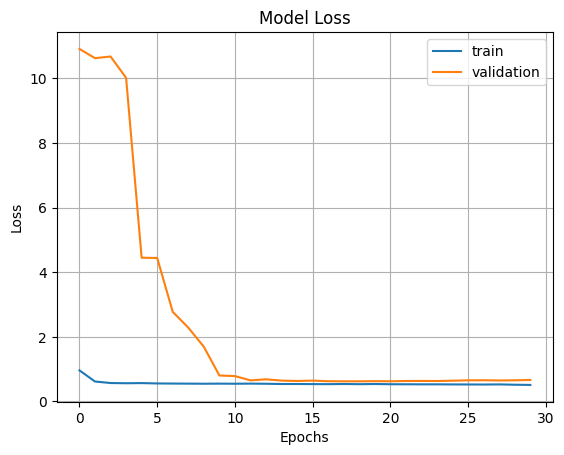

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

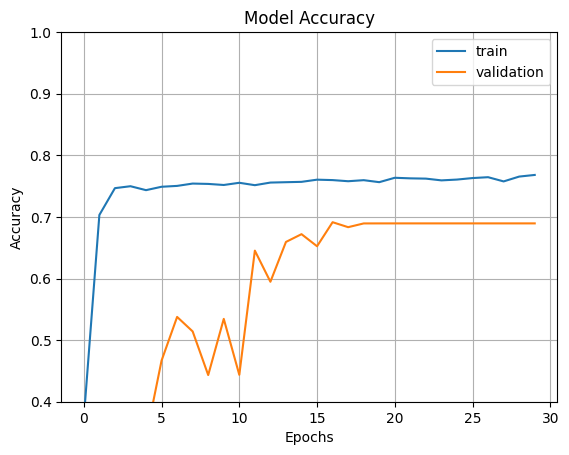

In [29]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [30]:
prediction = model.predict(val_image_array)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-28..1099].


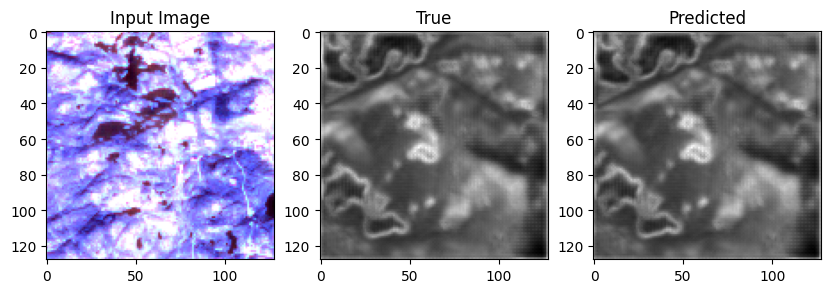

In [31]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_image[0][:, :, :3])

plt.subplot(1, 3, 2)
plt.title("True")
plt.imshow(prediction[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted")
plt.imshow(prediction[0].squeeze(), cmap='gray')